In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
import rdkit
import pydantic
from rxnmapper import RXNMapper
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display

In [2]:
# add atom index on structure
def moveAtomMapsToNotes(m):
    for at in m.GetAtoms():
        if at.GetIdx():
            at.SetProp("atomNote",str(at.GetIdx()))
    return m

# SM risk

## Get number of rings

In [10]:
mol = Chem.MolFromSmiles("C12CCC(C2)C3=C1C=CC=C3")
mol.GetRingInfo().NumRings()

3

## Get number of chiral centers (stereogenic centers)

In order to detect chiral centers, the smiles has to contain @ symbol

In [3]:
mol = Chem.MolFromSmiles('O=C([C@H](C)O1)O[C@@H](C)C1=O')
chiral = Chem.FindMolChiralCenters(mol)
chiral

[(2, 'S'), (6, 'S')]

In [4]:
# number of chiral center
len(chiral)

2

## Number of annulated ring
if any atom in a ring is also in another ring, those two rings are annulated rings.

In [8]:
# return a list of lists indicating 2 annulated ring index
from itertools import combinations
def annulated_ring(mol):
    numring = mol.GetRingInfo().NumRings()
    connected = []
    if numring>1:
        ringindex = list(range(numring)) # store ring index in a list
        ring_combinations = list(combinations(ringindex,2)) # combinations of any two of the rings
        for comb in ring_combinations:
            ring1 = comb[0]
            ring2 = comb[1]
            check = any(atom in mol.GetRingInfo().AtomRings()[ring1] for atom in mol.GetRingInfo().AtomRings()[ring2]) # if any atom in one ring is also in another ring, return True
            if check:
                annulated = [ring1,ring2]
                connected.append(annulated)
    return connected

In [9]:
annulated_ring_num = set([x for xs in connected for x in xs]) # flatten the nested list to a set
len(annulated_ring_num) # the length of the set is the number of annulated ring

3

### Examples

In [9]:
mol = Chem.MolFromSmiles("O=C1C2=CC(F)=CC=C2NC3(CCNCC3)C1")
connected = annulated_ring(mol) 
connected

[[0, 1], [0, 2]]

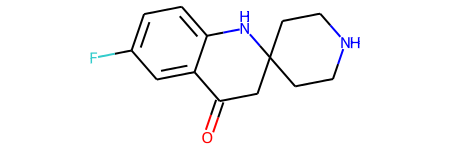

In [10]:
mol

以下分子的情况不用考虑(即有多组annulated rings)，由于结构复杂一般不会出现在SM中

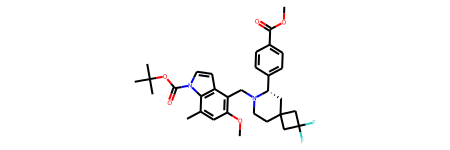

In [3]:
mol = Chem.MolFromSmiles("CC1=CC(OC)=C(CN2CCC3(CC(F)(F)C3)C[C@H]2C4=CC=C(C(OC)=O)C=C4)C5=C1N(C(OC(C)(C)C)=O)C=C5")
mol

## Number of substituted aryls or C=C double bond

### Prepare functions to detect aromatic rings, annulated aromatic ring group

In [14]:
# To detect aromatic rings, loop over the bonds in each ring and flag the ring as aromatic if all bonds are aromatic:
def isRingAromatic(mol,ring_idx):
        bondRing = mol.GetRingInfo().BondRings()[ring_idx] # return all bonds ids in the ring with ring index ring_idx
        for bondid in bondRing:
            if not mol.GetBondWithIdx(bondid).GetIsAromatic(): # if any bond is NOT aromatic, return False
                return False
        return True


# return the list of aromatic ring index, i.e which ring is aromatic
def aroma_ring_index(mol):
    aromatic_ring = []
    num_ring = mol.GetRingInfo().NumRings()
    for i in range(num_ring):
        isArom = isRingAromatic(mol, i)
        if isArom:
            aromatic_ring.append(i)
    return aromatic_ring

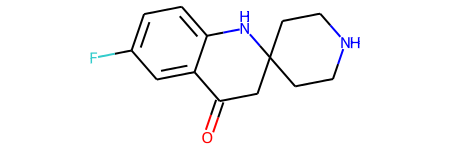

In [3]:
# example
mol = Chem.MolFromSmiles("O=C1C2=CC(F)=CC=C2NC3(CCNCC3)C1")
mol

In [4]:
aroma_ring_index(mol)

[1]

### return aromatic ring group

In [11]:
# Get annulated aromatic ring index (a list of annulated ring lists)
from itertools import combinations
def annulated_aromatic_ring(mol):
    aromatic_ring_idx = aroma_ring_index(mol)
    connected = []
    if len(aromatic_ring_idx)>1:
        ring_combinations = list(combinations(aromatic_ring_idx,2))
        for comb in ring_combinations:
            ring1 = comb[0]
            ring2 = comb[1]
            check = any(atom in mol.GetRingInfo().AtomRings()[ring1] for atom in mol.GetRingInfo().AtomRings()[ring2]) # if any atom in one ring is also in another ring, return True
            if check:
                annulated = [ring1,ring2]
                connected.append(annulated)
    return connected

In [41]:
# store annulated rings and separate rings in sublist
def aromatic_group(mol):
    aromatic_ring_idx = aroma_ring_index(mol)
    group = []
    # return a list of lists indicating 2 annulated aromatic ring index
    connected = annulated_aromatic_ring(mol)
    # if there is annulated aromatic ring             
    if len(connected)>0:
        annulated_aromatic_idx = set([x for xs in connected for x in xs]) # flatten the nested list to a set
        group.append(list(annulated_aromatic_idx))
        for i in aromatic_ring_idx:     # if there are separate aromatic rings, add them in the group
            if i not in annulated_aromatic_idx:
                group.append([i])
    else: # if all aromatic rings are separate
        for i in aromatic_ring_idx:
            group.append([i])
    # if there is no aromatic rings, return an empty list        
    return group

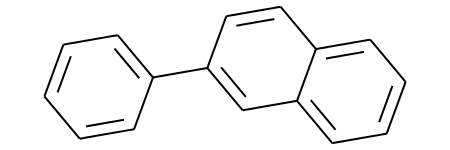

In [12]:
# example
mol = Chem.MolFromSmiles("C12=CC=CC=C1C=CC(C3=CC=CC=C3)=C2")
mol

In [15]:
annulated_aromatic_ring(mol)

[[0, 1]]

In [18]:
aromatic_group(mol)

[[0, 1], [2]]

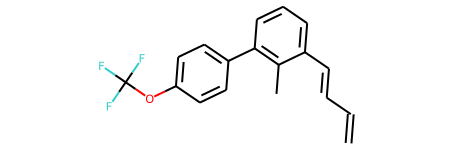

In [11]:
# example
mol = Chem.MolFromSmiles("CC1=C(C2=CC=C(OC(F)(F)F)C=C2)C=CC=C1/C=C/C=C")
mol

In [12]:
aromatic_group(mol)

[[0], [1]]

### return aromatic ring group(complex situation) (skip)
e.g. [1,2],[2,3],[4,5]

In [24]:
# return aromatic ring group
# construct graph from annulated aromatic rings, return all nodes of one tree in a sublist
# first get annulated aromatic ring index (a list of annulated ring lists)
from itertools import combinations
def annulated_aromatic_ring(mol):
    aromatic_ring_idx = aroma_ring_index(mol)
    connected = []
    if len(aromatic_ring_idx)>1:
        ring_combinations = list(combinations(aromatic_ring_idx,2))
        for comb in ring_combinations:
            ring1 = comb[0]
            ring2 = comb[1]
            check = any(atom in mol.GetRingInfo().AtomRings()[ring1] for atom in mol.GetRingInfo().AtomRings()[ring2]) # if any atom in one ring is also in another ring, return True
            if check:
                annulated = [ring1,ring2]
                connected.append(annulated)
    return connected

# second construct graph from annulated aromatic rings
# e.g. [1,2],[2,3],[4,5]
import igraph as ig
# return aromatic ring group, including separate rings
def aromatic_ring_group(mol):
    group = []  
    aromatic_ring_idx = aroma_ring_index(mol) 
    connected_full = annulated_aromatic_ring(mol)
    annulated_aromatic_idx = []
    
    if len(annulated_aromatic_ring(mol))>0:
        annulated_aromatic_idx = list({value for sub in connected_full for value in sub})
        n_node = len(annulated_aromatic_idx)
        g = ig.Graph(n=n_node, edges = connected_full, directed=True)

# third return the members of each grouped aromatic rings
# get the root node (indegree==0)
        root = []
        for i in annulated_aromatic_idx:
            deg = g.vs[i].indegree()
            if deg == 0:
                root.append(i)
       
        for i in root:
            node = g.dfs(i)[0] 
            group.append(node)
    
    for i in aromatic_ring_idx:     # if there are separate aromatic rings, add them in the group
        if i not in annulated_aromatic_idx:
            group.append([i])
    
    return group     

### Return the number of substituted aryls + number of C=C outside aromatic ring
rule: if the neighbors of aromatic atoms are not in the same ring or annulated ring or H, this aromatic ring is a substituted aryl and count 1   
if outside the aromatic ring there are C=C bonds, count number of such bonds        
sum the number of substituted aryl and number of C=C bonds

In [23]:
# if there is double bond and the atoms on the bond are C, C, count the number of bonds
def cc_doublebond(mol):
    num = 0
    bonds = mol.GetBonds()
    for i in bonds:
        t = str(i.GetBondType())
        if t =="DOUBLE":
            atombegin = i.GetBeginAtom().GetSymbol()
            atomend = i.GetEndAtom().GetSymbol()
            if atombegin =="C" and atomend =="C":
                num += 1
    return num

In [34]:
# example
m = Chem.MolFromSmiles('C=C')
cc_doublebond(m)

1

In [21]:
# return the sum of the number of substituted aryl and number of C=C bonds
def num_substit(mol):
    aromatic_ring = aroma_ring_index(mol) # list of aromatic ring index
    group = aromatic_ring_group(mol)  # list of aromatic group list
    num_aryl = 0
    doublebond = cc_doublebond(mol)

    if len(aromatic_ring)>0:
        for sublist in group: # for each aromatic ring group
            annulated_ring_atoms = []
            for i in sublist: # for each aromatic ring
                count = False
                aromaticatoms = mol.GetRingInfo().AtomRings()[i]  # atom index in the aromatic ring
                annulated_ring_atoms.append(aromaticatoms)
                
            atom_list = set([item for t in annulated_ring_atoms for item in t]) # unique atom index for each aromatic ring group
        
            for atomidx in atom_list:
                nbrset = mol.GetAtomWithIdx(atomidx).GetNeighbors() # get the neighbors 
                for nbratom in nbrset:
                    if nbratom.GetIdx() not in atom_list:  # if any neighbor is not in the same aromatic ring group, count as substituted aryl
                        count = True
                        num_aryl = num_aryl+1
                        break
                if count:  # end the loop of atoms in the current aromatic ring group 
                    break

    total = num_aryl + doublebond

    return total

### examples

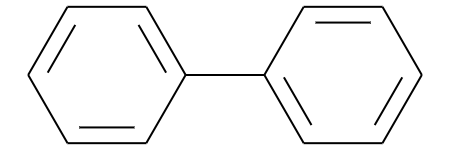

In [19]:
mol = Chem.MolFromSmiles("C1(C2=CC=CC=C2)=CC=CC=C1")
mol

In [26]:
num_substit(mol)

2

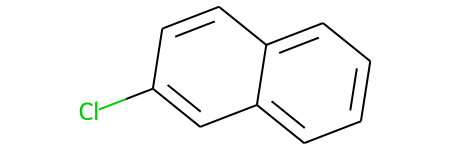

In [27]:
mol = Chem.MolFromSmiles("ClC1=CC2=CC=CC=C2C=C1")
mol

In [28]:
num_substit(mol)

1

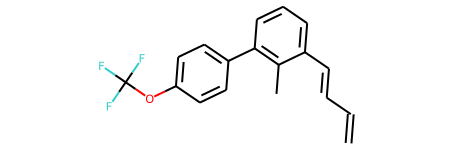

In [29]:
mol = Chem.MolFromSmiles("CC1=C(C2=CC=C(OC(F)(F)F)C=C2)C=CC=C1/C=C/C=C")
mol

In [30]:
num_substit(mol) 

4

In [109]:
mol = Chem.MolFromSmiles("CC")
num_substit(mol) 

0

## Number of bond forming stages to API

### Get atom map indices with RXNMapper

In [3]:
from rxnmapper import RXNMapper
# get mapped reaction smarts
def rxn_mapper(reaction_smiles):
    mapper = RXNMapper()
    rxns = [reaction_smiles]
    results = mapper.get_attention_guided_atom_maps(rxns)
    smarts = results[0]["mapped_rxn"]
    return smarts

In [31]:
from collections import namedtuple
AtomInfo = namedtuple('AtomInfo',('mapnum','reactant','reactantAtom','product','productAtom'))

# figure out reacting atoms(atoms that change in the reaction) in the reactants and map them to the products
# use the following function to get reacting atoms: rxn1.Initialize() reacting_atom = rxn1.GetReactingAtoms() 
def map_reacting_atoms_to_products(rxn,reactingAtoms):
    ''' figures out which atoms in the products each reacting atom in the reactants maps to '''
    res = []
    for ridx,reacting in enumerate(reactingAtoms):
        reactant = rxn.GetReactantTemplate(ridx)
        for raidx in reacting:
            mapnum = reactant.GetAtomWithIdx(raidx).GetAtomMapNum()
            foundit=False
            for pidx,product in enumerate(rxn.GetProducts()):
                for paidx,patom in enumerate(product.GetAtoms()):
                    if patom.GetAtomMapNum()==mapnum:
                        res.append(AtomInfo(mapnum,ridx,raidx,pidx,paidx))
                        foundit = True
                        break
                    if foundit:
                        break
    return res



example

In [32]:
rxn_smarts = rxn_mapper("FC1=CC=C(N)C(C(C)=O)=C1.O=C1CCN(C(OC(C)(C)C)=O)CC1>>FC1=CC=C(N)C(C(CC2(O)CCN(C(OC(C)(C)C)=O)CC2)=O)=C1")
rxn_smarts

'[CH3:13][C:14](=[O:15])[c:16]1[cH:17][c:18]([F:19])[cH:20][cH:21][c:22]1[NH2:23].[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][C:11](=[O:12])[CH2:24][CH2:25]1>>[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][C:11]([OH:12])([CH2:13][C:14](=[O:15])[c:16]2[cH:17][c:18]([F:19])[cH:20][cH:21][c:22]2[NH2:23])[CH2:24][CH2:25]1'

In [33]:
rxn1 = rdChemReactions.ReactionFromSmarts(rxn_smarts)
rxn1.Initialize()
reacting_atom = rxn1.GetReactingAtoms() # return atoms of each reactant that change in the reaction
reacting_atom

((0, 3, 4, 5, 7, 8, 9), (10, 11))

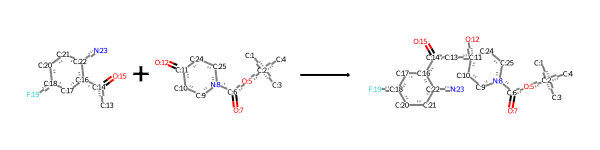

In [7]:
rxn1

In [34]:
map_reacting_atoms_to_products(rxn1,reacting_atom)

[AtomInfo(mapnum=13, reactant=0, reactantAtom=0, product=0, productAtom=12),
 AtomInfo(mapnum=16, reactant=0, reactantAtom=3, product=0, productAtom=15),
 AtomInfo(mapnum=17, reactant=0, reactantAtom=4, product=0, productAtom=16),
 AtomInfo(mapnum=18, reactant=0, reactantAtom=5, product=0, productAtom=17),
 AtomInfo(mapnum=20, reactant=0, reactantAtom=7, product=0, productAtom=19),
 AtomInfo(mapnum=21, reactant=0, reactantAtom=8, product=0, productAtom=20),
 AtomInfo(mapnum=22, reactant=0, reactantAtom=9, product=0, productAtom=21),
 AtomInfo(mapnum=11, reactant=1, reactantAtom=10, product=0, productAtom=10),
 AtomInfo(mapnum=12, reactant=1, reactantAtom=11, product=0, productAtom=11)]

In [35]:
# new bond is identified if two adjacent atoms in product are NOT adjacent in reactant

def get_mapped_neighbors(atom):
    ''' test all mapped neighbors of a mapped atom'''  # return the neighbors of reacting atom, which are also present in the product
    res = {}
    amap = atom.GetAtomMapNum()
    if not amap:
        return res
    for nbr in atom.GetNeighbors():
        nmap = nbr.GetAtomMapNum()
        if nmap:
            if amap>nmap:
                res[(nmap,amap)] = (atom.GetIdx(),nbr.GetIdx())
            else:
                res[(amap,nmap)] = (nbr.GetIdx(),atom.GetIdx())
    return res

BondInfo = namedtuple('BondInfo',('product','productAtoms','productBond','status'))
def find_modifications_in_products(rxn):
    ''' returns a 2-tuple with the modified atoms and bonds from the reaction '''
    reactingAtoms = rxn.GetReactingAtoms()  # returns a sequence of sequences with the atoms that change in the reaction
    amap = map_reacting_atoms_to_products(rxn,reactingAtoms)
    res = []
    seen = set() # store the bond of reacting atom and its neighbors
    # this is all driven from the list of reacting atoms:
    for _,ridx,raidx,pidx,paidx in amap:
        reactant = rxn.GetReactantTemplate(ridx)
        ratom = reactant.GetAtomWithIdx(raidx)
        product = rxn.GetProductTemplate(pidx)
        patom = product.GetAtomWithIdx(paidx)

        rnbrs = get_mapped_neighbors(ratom) # neighbors of reacting atoms in reactant
        pnbrs = get_mapped_neighbors(patom) # neighbors of reacting atoms in product
        for tpl in pnbrs:
            pbond = product.GetBondBetweenAtoms(*pnbrs[tpl])
            if (pidx,pbond.GetIdx()) in seen:
                continue
            seen.add((pidx,pbond.GetIdx()))
            if not tpl in rnbrs: # two adjacent atoms that are NOT neighbors in reactant
                # new bond in product
                res.append(BondInfo(pidx,pnbrs[tpl],pbond.GetIdx(),'New'))
            # The following codes are for changed bond, can be deleted
            # else:
            #     # present in both reactants and products, check to see if it changed
            #     rbond = reactant.GetBondBetweenAtoms(*rnbrs[tpl])
            #     if rbond.GetBondType()!=pbond.GetBondType():
            #         res.append(BondInfo(pidx,pnbrs[tpl],pbond.GetIdx(),'Changed'))
    return amap,res

example

In [36]:
atms,bnds = find_modifications_in_products(rxn1)
bnds

[BondInfo(product=0, productAtoms=(12, 10), productBond=21, status='New')]

### In iropa, extract reaction sequence from SM of interest to IP

Loop over each reaction step, count 1 if there is any new bond forming in this step

## Calculate % w/w of API

In [39]:
rxn_smarts = rxn_mapper("FC1=CC=C(N)C(C(C)=O)=C1.O=C1CCN(C(OC(C)(C)C)=O)CC1.O=C(NCC(C=C1)=CC=C1F)N2C=NC=C2>>O=C(CC1(CCN(C(NCC2=CC=C(F)C=C2)=O)CC1)N3)C4=C3C=CC(F)=C4")
rxn_smarts

'[O:1]=[C:2]([CH3:3])[c:28]1[c:22]([NH2:21])[cH:23][cH:24][c:25]([F:26])[cH:27]1.CC(C)(C)OC(=O)[N:7]1[CH2:6][CH2:5][C:4](=O)[CH2:20][CH2:19]1.c1cn([C:8](=[O:9])[NH:10][CH2:11][c:12]2[cH:13][cH:14][c:15]([F:16])[cH:17][cH:18]2)cn1>>[O:1]=[C:2]1[CH2:3][C:4]2([CH2:5][CH2:6][N:7]([C:8](=[O:9])[NH:10][CH2:11][c:12]3[cH:13][cH:14][c:15]([F:16])[cH:17][cH:18]3)[CH2:19][CH2:20]2)[NH:21][c:22]2[cH:23][cH:24][c:25]([F:26])[cH:27][c:28]21'

### visualization

In [37]:
def draw_chemical_reaction(smiles, highlightByReactant=False, font_scale=1.5):
    rxn = rdChemReactions.ReactionFromSmarts(smiles,useSmiles=True)
    trxn = rdChemReactions.ChemicalReaction(rxn)
    # move atom maps to be annotations:
    for m in trxn.GetReactants():
        moveAtomMapsToNotes(m)
    for m in trxn.GetProducts():
        moveAtomMapsToNotes(m)
    d2d = rdMolDraw2D.MolDraw2DSVG(800,300)
    d2d.drawOptions().annotationFontScale=font_scale
    d2d.DrawReaction(trxn,highlightByReactant=highlightByReactant)

    d2d.FinishDrawing()

    return d2d.GetDrawingText()

def moveAtomMapsToNotes(m):
    for at in m.GetAtoms():
        if at.GetAtomMapNum():
            at.SetProp("atomNote",str(at.GetAtomMapNum()))

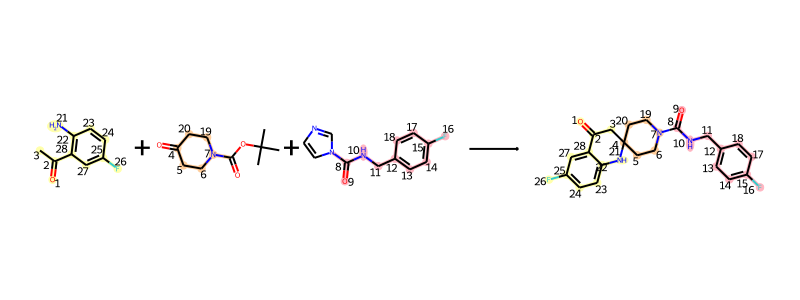

In [40]:
SVG(draw_chemical_reaction(rxn_smarts,highlightByReactant=True))

In [ ]:
# get atom index
for at in atoms:
    atom_index = at.GetIdx()

# get atom map index
for at in atoms:
    map_idx = at.GetAtomMapNum()


### Alternative approach: Tracking by step (skip)
track SM contributed part:                        
1. Get atom index of SM contributed part in product
2. Get the mapping between the same molecule when it serves as product and reactant:      
   potential method: reactant_in_next_reaction.GetSubstructMatches(product)
3. Get the atom index of contributed part in reactant_in_next_reaction
4. step 1

for the last reaction step, sum mass of all atoms with map atom !=0 in step 4                    
note: the following codes don't include step 2

### Example

In [1]:
import pandas as pd

In [2]:
example = pd.read_excel("SM_track_example.xlsx",sheet_name ="B_smarts")
sequence = list(example["reaction_smarts"])

#### Track B

In [140]:
sequence[0]

'[CH3:13][C:14](=[O:15])[c:16]1[cH:17][c:18]([F:19])[cH:20][cH:21][c:22]1[NH2:23].[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][C:11](=[O:12])[CH2:24][CH2:25]1>>[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[N:8]1[CH2:9][CH2:10][C:11]([OH:12])([CH2:13][C:14](=[O:15])[c:16]2[cH:17][c:18]([F:19])[cH:20][cH:21][c:22]2[NH2:23])[CH2:24][CH2:25]1'

In [141]:
sequence[1]

'[CH3:1][C:5]([CH3:4])([O:7][C:2](=[O:8])[N:18]1[CH2:17][CH2:16][C:15]([OH:9])([CH2:14][C:13](=[O:12])[c:28]2[c:22]([NH2:21])[cH:23][cH:24][c:25]([F:26])[cH:27]2)[CH2:20][CH2:19]1)[CH3:10]>>[CH3:1][c:2]1[cH:3][cH:4][c:5]([S:6](=[O:7])(=[O:8])[OH:9])[cH:10][cH:11]1.[O:12]=[C:13]1[CH2:14][C:15]2([CH2:16][CH2:17][NH:18][CH2:19][CH2:20]2)[NH:21][c:22]2[cH:23][cH:24][c:25]([F:26])[cH:27][c:28]21'

In [142]:
sequence[2]

'Cc1ccc(S(=O)(=O)O)cc1.c1cn([C:8](=[O:9])[NH:10][CH2:11][c:12]2[cH:13][cH:14][c:15]([F:16])[cH:17][cH:18]2)cn1.[O:1]=[C:2]1[CH2:3][C:4]2([CH2:5][CH2:6][NH:7][CH2:19][CH2:20]2)[NH:21][c:22]2[cH:23][cH:24][c:25]([F:26])[cH:27][c:28]21>>[O:1]=[C:2]1[CH2:3][C:4]2([CH2:5][CH2:6][N:7]([C:8](=[O:9])[NH:10][CH2:11][c:12]3[cH:13][cH:14][c:15]([F:16])[cH:17][cH:18]3)[CH2:19][CH2:20]2)[NH:21][c:22]2[cH:23][cH:24][c:25]([F:26])[cH:27][c:28]21'

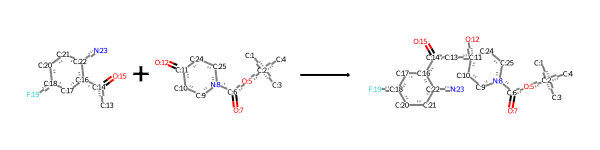

In [5]:
reaction1 = rdChemReactions.ReactionFromSmarts(sequence[0])
reaction1

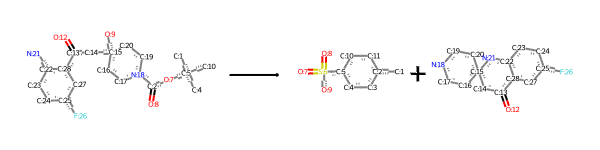

In [17]:
reaction2

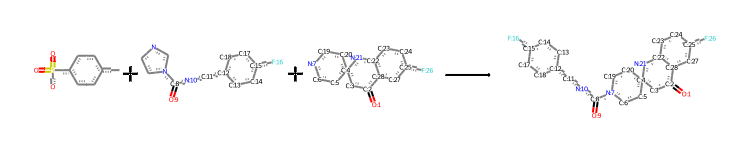

In [6]:
reaction3 = rdChemReactions.ReactionFromSmarts(sequence[2])
reaction3

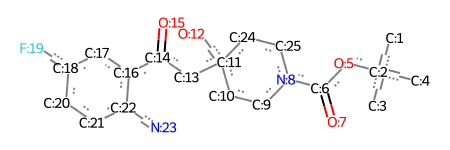

In [65]:
c_prod = reaction1.GetProductTemplate(0)
c_prod

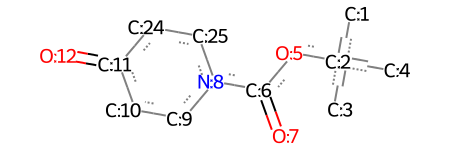

In [8]:
b = reaction1.GetReactantTemplate(1)
b

In [11]:
# get atom index of mapped part of B in C
atom_b = b.GetAtoms()
atom_map_collection = []
for at in atom_b:
    if at.GetAtomMapNum()!=0:  # as long as the atom map num in reactant !=0, this atom must be present in product
        atom_map_collection.append(at.GetAtomMapNum())
        
atom_c_prod = c_prod.GetAtoms()
atom_index_collection = []
for at in atom_c_prod:
    map_idx = at.GetAtomMapNum()
    if map_idx in atom_map_collection:   
        atom_index = at.GetIdx()
        atom_index_collection.append(atom_index)  # store the product ATOM INDEX in list if its map index appear in reactant B
atom_index_collection

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 23, 24]

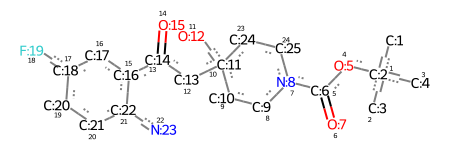

In [22]:
moveAtomMapsToNotes(c_prod)

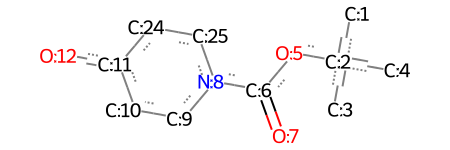

In [12]:
# convert mapped part to smarts and then mol object
patten_bc = Chem.MolFragmentToSmiles(c_prod, atom_index_collection) # smarts
patten_bc_mol = Chem.MolFromSmarts(patten_bc)
patten_bc_mol

In [67]:
# get sub structure match in next reaction
reaction2 = rdChemReactions.ReactionFromSmarts(sequence[1])
c_react = reaction2.GetReactantTemplate(0)

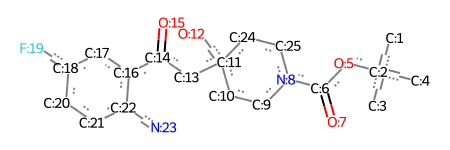

In [66]:
c_prod

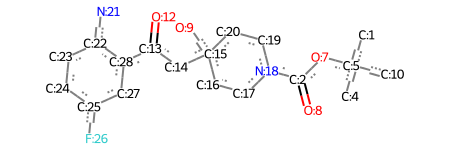

In [68]:
c_react

In [69]:
c_react.GetSubstructMatches(c_prod)

((0,
  1,
  2,
  24,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  21,
  19,
  20,
  18,
  17,
  15,
  16,
  22,
  23),)

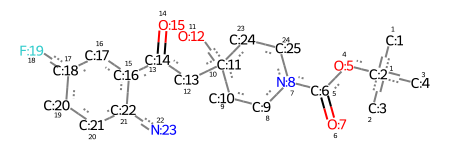

In [74]:
moveAtomMapsToNotes(c_prod)

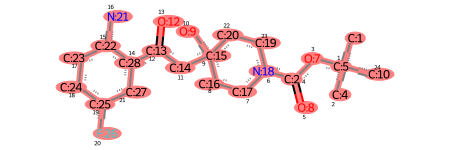

In [75]:
moveAtomMapsToNotes(c_react)

In [22]:
# get substructure from reactant in reaction 2 that matches with patten_bc_mol from reaction 1
atom_idx_match = c_react.GetSubstructMatches(patten_bc_mol)
atom_idx_match = [item for t in atom_idx_match for item in t]
map_index_cd = []
c_react_atoms = c_react.GetAtoms()
for i in atom_idx_match:
    map_idx = c_react_atoms[i].GetAtomMapNum()
    if map_idx !=0:   # find which atoms in matched substructure end up in product
        map_index_cd.append(map_idx)
map_index_cd

[1, 5, 4, 10, 7, 2, 8, 18, 17, 16, 15, 9, 20, 19]

In [15]:
c_react.GetSubstructMatches(patten_bc_mol)

((0, 1, 2, 24, 3, 4, 5, 6, 7, 8, 9, 10, 22, 23),)

In [23]:
# get atom index of matched part in product
num_prod = reaction2.GetNumProductTemplates()
atom_index_collection = []
for i in range(num_prod):
    atom_index = []
    prod = reaction2.GetProducts()[i]
    atoms = prod.GetAtoms()
    for at in atoms:
        atommap = at.GetAtomMapNum()
        if atommap in map_index_cd:
            atom_index.append(at.GetIdx())
    atom_index_collection.append(atom_index)  # store the product ATOM INDEX 
    

In [134]:
atom_index_collection

[[0, 1, 3, 4, 6, 7, 8, 9], [3, 4, 5, 6, 7, 8]]

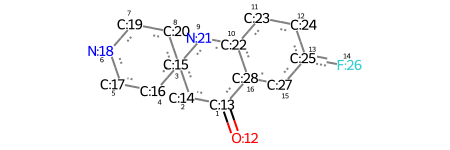

In [28]:
moveAtomMapsToNotes(reaction2.GetProducts()[1])

In [24]:
# convert mapped part to smarts and then mol object
pattern_cd = []
num = len(atom_index_collection)
for i in range(num):
    pattern_cd.append(Chem.MolFragmentToSmiles(reaction2.GetProducts()[i], atom_index_collection[i]))
pattern_cd

['[CH3:1][c:2].[cH:4][c:5][cH:10].[O:7].[O:8].[OH:9]',
 '[C:15]1[CH2:16][CH2:17][NH:18][CH2:19][CH2:20]1']

In [26]:
pattern_cd_mol = []
for i in pattern_cd:
    mol = Chem.MolFromSmarts(i)
    pattern_cd_mol.append(mol)

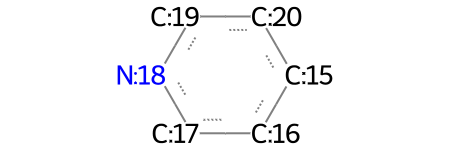

In [148]:
pattern_cd_mol[1]

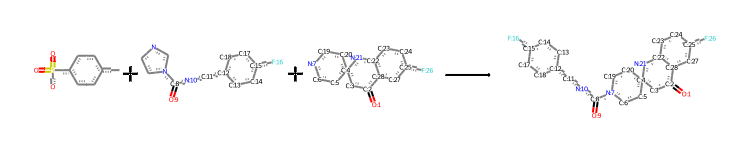

In [145]:
reaction3 = rdChemReactions.ReactionFromSmarts(sequence[2])
reaction3

In [18]:
# get sub structure match in next reaction
reaction3 = rdChemReactions.ReactionFromSmarts(sequence[2])
d_react_1 = reaction3.GetReactants()[0]
d_react_2 = reaction3.GetReactants()[2]
f = reaction3.GetProducts()[0]

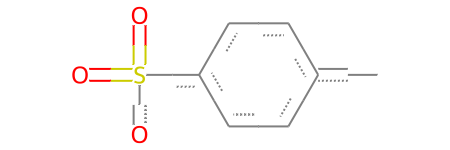

In [28]:
d_react_1

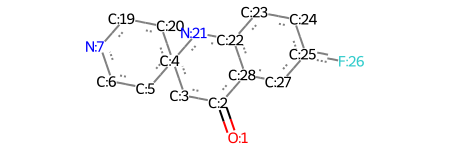

In [29]:
d_react_2

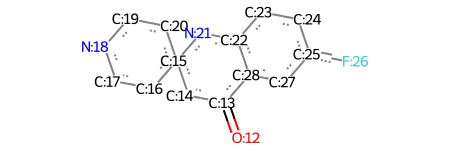

In [36]:
d_prod_2

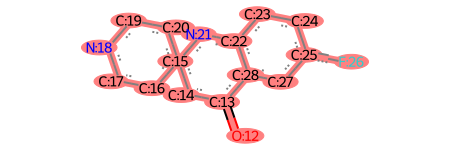

In [37]:
d_prod_2 = reaction2.GetProductTemplate(1)
d_prod_2.GetSubstructMatches(Chem.MolFromSmarts("[O:12]=[C:13]1[CH2:14][C:15]2([CH2:16][CH2:17][NH:18][CH2:19][CH2:20]2)[NH:21][c:22]2[cH:23][cH:24][c:25]([F:26])[cH:27][c:28]21"))
d_prod_2

In [31]:
# get atom index of substructure match 
map_index_df = d_react_2.GetSubstructMatches(pattern_cd_mol[1])
map_index_df = [item for t in map_index_df for item in t]
d_react_2_atoms = d_react_2.GetAtoms()
atom_index = []
for i in map_index_df:
    atom_map = d_react_2_atoms[i].GetAtomMapNum()
    if atom_map != 0:
        atom_index.append(i)
    
atom_index    

[3, 4, 5, 6, 7, 8]

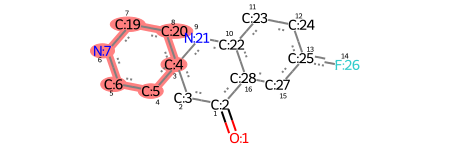

In [158]:
moveAtomMapsToNotes(d_react_2)

In [159]:
# get matched atoms mass sum
mass = 0
for i in atom_index:
    mass =  mass + d_react_2.GetAtoms()[i].GetMass()
    if d_react_2.GetAtoms()[i].GetImplicitValence() == -1:
        h = 0
    else:
        h = d_react_2.GetAtoms()[i].GetTotalNumHs()
        mass = mass + h
    
mass

83.062

In [45]:
f.GetSubstructMatches(Chem.MolFromSmarts(p))

((0, 1, 2, 3, 4, 5, 6, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27),)

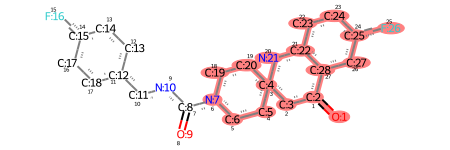

In [46]:
f

In [162]:
from rdkit.Chem import Descriptors
mass/Descriptors.MolWt(f)

0.21551370733808312